# HW4 - Statistics and Data Analysis
## Differential Gene Expression in Acute Myocardial Infraction

### 1. Introduction
Gene expression describes the process in which genes that are coded in the DNA of living organisms are transcribed into mRNA. This is part of the bigger process in which genes are being copied (transcribed), processed, translated and modified into the final product, usually a protein. Gene expression profiling measures the levels at which mRNA molecules pertaining to the genes profiled are observed in a sample.

In this exercise, we will perform guided analysis, comparing expression profiles of circulating endothelial cells (CECs) in patients with acute myocardial infraction to CECs in healthy controls. A comparison of two sample classes.

### 2. The Data Set
The data set was taken from:

> 1) Dataset record in NCBI:

>> https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE66360

> 2) Published paper: Muse et al, Sci Rep 2017

>> https://www.nature.com/articles/s41598-017-12166-0

We extracted the data matrix and provide it as a separate csv attachment (link to download). The csv file needs to be pre-processed before moving to the main analysis steps. Some information should be removed but make sure that you keep all information that is important for the analysis. Specifically, all expression values should be kept and the label of each sample (H – Healthy, M - Myocardial Infraction).

The paper describes a study that seeks to develop an expression-based signature that can detect AMI in patients in a non-invasive manner, by profiling CECs.

In [ ]:
#!pip install -U -q scipy==1.7.0

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums, ttest_ind, binom, kendalltau, mannwhitneyu
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('AMI_GSE66360_series_matrix.csv', index_col=0, header=None, skiprows=59, encoding = "iso-8859-1")
df.drop('ID_REF',axis=0, inplace=True)

In [ ]:
df.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Class,H,H,H,H,H,H,H,H,H,H,H,H,H,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,H,H,H,H,H,H,...,M,M,M,M,M,M,M,M,M,M,M,M,M,M,H,H,H,H,H,H,H,H,H,H,H,H,H,M,M,M,M,M,M,M,M,M,M,M,M,M
1007_s_at,5.866377893,4.948736331,5.148384393,5.064418945,5.017832878,5.116153518,5.431328058,5.235270857,5.773528455,6.016415473,5.984604923,6.444126136,4.919960058,5.511751997,5.663843103,4.562416458,5.237784412,5.310518957,5.249898632,5.5115008,4.949107666,5.15158282,5.126908181,5.539606881,5.283399432,5.288731919,6.555454506,5.566308023,5.765327282,5.138168169,6.13588372,5.421968309,6.163869441,6.061935785,6.837306739,5.226222617,6.137944876,6.444286484,6.691462908,7.29112731,...,5.625816635,6.622018947,5.60617754,5.623932093,5.144285645,5.669552921,5.518466028,5.052428251,5.003858141,6.162638582,6.17393294,5.601771579,7.522880565,5.344028996,5.420405456,6.644434374,5.831682526,6.726176315,5.653633195,5.978694924,6.242491268,5.296551574,5.547582561,5.916522943,5.889478152,6.195676155,6.112345496,5.432319923,4.71270991,5.266184645,5.419481538,5.057716465,5.996493392,5.343132759,5.558892254,6.472517225,5.678815851,5.653286378,6.013841046,5.465333944
1053_at,8.22579012,7.525865369,7.764636529,7.198461482,7.831450258,7.203591859,7.694550756,7.760259212,8.279814404,7.580840863,7.552293801,8.158129288,7.799660696,7.856591385,6.84961761,7.956047464,7.710326637,7.984930964,8.708723479,8.087233588,7.87213707,8.146643771,7.904486787,7.590671834,7.527726269,7.911499462,7.481720167,7.589782699,7.652969521,7.371917749,7.540214522,8.388447716,7.738484261,7.830074254,8.024727782,6.805195785,7.695904083,7.808027698,6.908924364,5.840951999,...,8.981583294,5.241894547,7.586670685,8.31690199,7.359245967,8.219956553,8.387229227,5.919230768,7.409555572,5.759000796,7.63174102,7.119643481,7.627191039,8.714694376,8.051429194,8.034722521,7.149726942,7.992437708,6.324309007,6.869008279,7.336013324,5.60679895,6.272012275,8.091684049,7.513029039,8.307556575,7.377022551,7.448598432,8.171620187,5.657304845,7.226347747,7.105537863,5.354105386,8.271499725,5.96334574,8.261421952,6.925752665,7.918424183,7.442701377,9.225221352
117_at,6.17973231,6.628137025,5.859151477,5.974135101,6.793079158,6.43522914,6.320546126,6.48359047,6.387779205,6.307065808,5.899590353,5.753603452,5.88034165,7.006409059,6.81882596,6.524126223,7.196083901,7.691033654,9.468659375,7.496835018,6.577697593,7.188135534,6.005948079,6.854797201,6.078463093,8.215252394,8.618610576,7.630854084,9.881015625,6.49423773,8.415817957,10.40662804,10.55390549,9.281038245,6.312273204,6.733494503,6.136813754,7.929139871,8.378924593,7.376952411,...,6.505866838,6.700616936,9.202061869,7.069372181,7.422027739,7.191427108,8.011480015,6.418589378,6.934743267,6.218757883,6.382497255,7.228285903,8.901739877,7.504153791,6.683245768,7.046562119,7.024473709,6.5390767,6.016342049,6.249161999,7.014301872,7.080036097,6.157005169,6.285221624,7.039645711,6.815898452,7.081594885,6.803709325,6.645631155,6.439076285,6.789500767,7.441939912,7.026928573,6.003972814,7.474325713,6.367759272,6.835755831,7.577034915,7.147417202,6.48112813
121_at,6.179477974,6.58288903,6.602134766,6.545904723,5.911542321,6.28542026,6.562315839,6.345887555,6.27280582,5.971847425,6.390802972,6.516452986,5.791862352,6.038037184,6.643061485,6.364274412,6.412886836,6.296482808,6.427513441,6.191955953,6.212988531,6.49887736,6.621110154,6.391190682,6.203988027,6.456057431,6.354805461,6.243215603,6.05956991,6.32585376,5.772115747,6.400146577,6.314747282,7.014390586,5.94397632,6.003585491,5.874295915,6.041638047,6.934797222,7.432125505,...,7.015511763,7.839276426,6.588715553,6.918176382,6.52166564,7.337135641,6.831247237,5.75306761,6.67937634,6.304337633,6.794505075,6.965

### 3. Analysis

#### a. High level description of the data and some pre-processing

###### 1) How many genes profiled?

In [ ]:
# count rows except for "Class" and "ID_REF"
n_genes = df.shape[0] - 1
print(f"Number of genes profiled: {n_genes}")

Number of genes profiled: 54675


##### 2) How many samples (subjects/patients) in total?

In [ ]:
# count number of columns in the DataFrame
n_samples = df.shape[1]
print(f"Number of samples (subjects/patients) in total: {n_samples}")

Number of samples (subjects/patients) in total: 99


##### 3) How many samples in each class?

In [ ]:
n_samples_per_class = df.loc['Class'].value_counts()
print(f"Number of Healthy samples: {n_samples_per_class['H']}")
print(f"Number of Myocardial samples: {n_samples_per_class['M']}")

Number of Healthy samples: 50
Number of Myocardial samples: 49


##### 4) If there are missing values, then remove the entire row (gene) from the data matrix. <br/> How many rows left now?

In [ ]:
df = df.dropna()

In [ ]:
# count rows except for "Class" and "ID_REF"
n_genes_no_missing_values = df.shape[0] - 1
print(f"Number of genes profiled with no missing values: {n_genes_no_missing_values}")

Number of genes profiled with no missing values: 54628


In [ ]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Class,H,H,H,H,H,H,H,H,H,H,H,H,H,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,M,H,H,H,H,H,H,...,M,M,M,M,M,M,M,M,M,M,M,M,M,M,H,H,H,H,H,H,H,H,H,H,H,H,H,M,M,M,M,M,M,M,M,M,M,M,M,M
1007_s_at,5.866377893,4.948736331,5.148384393,5.064418945,5.017832878,5.116153518,5.431328058,5.235270857,5.773528455,6.016415473,5.984604923,6.444126136,4.919960058,5.511751997,5.663843103,4.562416458,5.237784412,5.310518957,5.249898632,5.5115008,4.949107666,5.15158282,5.126908181,5.539606881,5.283399432,5.288731919,6.555454506,5.566308023,5.765327282,5.138168169,6.13588372,5.421968309,6.163869441,6.061935785,6.837306739,5.226222617,6.137944876,6.444286484,6.691462908,7.29112731,...,5.625816635,6.622018947,5.60617754,5.623932093,5.144285645,5.669552921,5.518466028,5.052428251,5.003858141,6.162638582,6.17393294,5.601771579,7.522880565,5.344028996,5.420405456,6.644434374,5.831682526,6.726176315,5.653633195,5.978694924,6.242491268,5.296551574,5.547582561,5.916522943,5.889478152,6.195676155,6.112345496,5.432319923,4.71270991,5.266184645,5.419481538,5.057716465,5.996493392,5.343132759,5.558892254,6.472517225,5.678815851,5.653286378,6.013841046,5.465333944
1053_at,8.22579012,7.525865369,7.764636529,7.198461482,7.831450258,7.203591859,7.694550756,7.760259212,8.279814404,7.580840863,7.552293801,8.158129288,7.799660696,7.856591385,6.84961761,7.956047464,7.710326637,7.984930964,8.708723479,8.087233588,7.87213707,8.146643771,7.904486787,7.590671834,7.527726269,7.911499462,7.481720167,7.589782699,7.652969521,7.371917749,7.540214522,8.388447716,7.738484261,7.830074254,8.024727782,6.805195785,7.695904083,7.808027698,6.908924364,5.840951999,...,8.981583294,5.241894547,7.586670685,8.31690199,7.359245967,8.219956553,8.387229227,5.919230768,7.409555572,5.759000796,7.63174102,7.119643481,7.627191039,8.714694376,8.051429194,8.034722521,7.149726942,7.992437708,6.324309007,6.869008279,7.336013324,5.60679895,6.272012275,8.091684049,7.513029039,8.307556575,7.377022551,7.448598432,8.171620187,5.657304845,7.226347747,7.105537863,5.354105386,8.271499725,5.96334574,8.261421952,6.925752665,7.918424183,7.442701377,9.225221352
117_at,6.17973231,6.628137025,5.859151477,5.974135101,6.793079158,6.43522914,6.320546126,6.48359047,6.387779205,6.307065808,5.899590353,5.753603452,5.88034165,7.006409059,6.81882596,6.524126223,7.196083901,7.691033654,9.468659375,7.496835018,6.577697593,7.188135534,6.005948079,6.854797201,6.078463093,8.215252394,8.618610576,7.630854084,9.881015625,6.49423773,8.415817957,10.40662804,10.55390549,9.281038245,6.312273204,6.733494503,6.136813754,7.929139871,8.378924593,7.376952411,...,6.505866838,6.700616936,9.202061869,7.069372181,7.422027739,7.191427108,8.011480015,6.418589378,6.934743267,6.218757883,6.382497255,7.228285903,8.901739877,7.504153791,6.683245768,7.046562119,7.024473709,6.5390767,6.016342049,6.249161999,7.014301872,7.080036097,6.157005169,6.285221624,7.039645711,6.815898452,7.081594885,6.803709325,6.645631155,6.439076285,6.789500767,7.441939912,7.026928573,6.003972814,7.474325713,6.367759272,6.835755831,7.577034915,7.147417202,6.48112813
121_at,6.179477974,6.58288903,6.602134766,6.545904723,5.911542321,6.28542026,6.562315839,6.345887555,6.27280582,5.971847425,6.390802972,6.516452986,5.791862352,6.038037184,6.643061485,6.364274412,6.412886836,6.296482808,6.427513441,6.191955953,6.212988531,6.49887736,6.621110154,6.391190682,6.203988027,6.456057431,6.354805461,6.243215603,6.05956991,6.32585376,5.772115747,6.400146577,6.314747282,7.014390586,5.94397632,6.003585491,5.874295915,6.041638047,6.934797222,7.432125505,...,7.015511763,7.839276426,6.588715553,6.918176382,6.52166564,7.337135641,6.831247237,5.75306761,6.67937634,6.304337633,6.794505075,6.965

##### 5) Pick 20 genes at random. Draw 20 pair boxplots in one figure comparing expression levels of each of these genes in the two classes M and H.

In [ ]:
random_genes = list(np.random.choice(df.index[1:], 20, replace=False))

In [ ]:
df.iloc[1:] = df.iloc[1:].apply(np.vectorize(float))

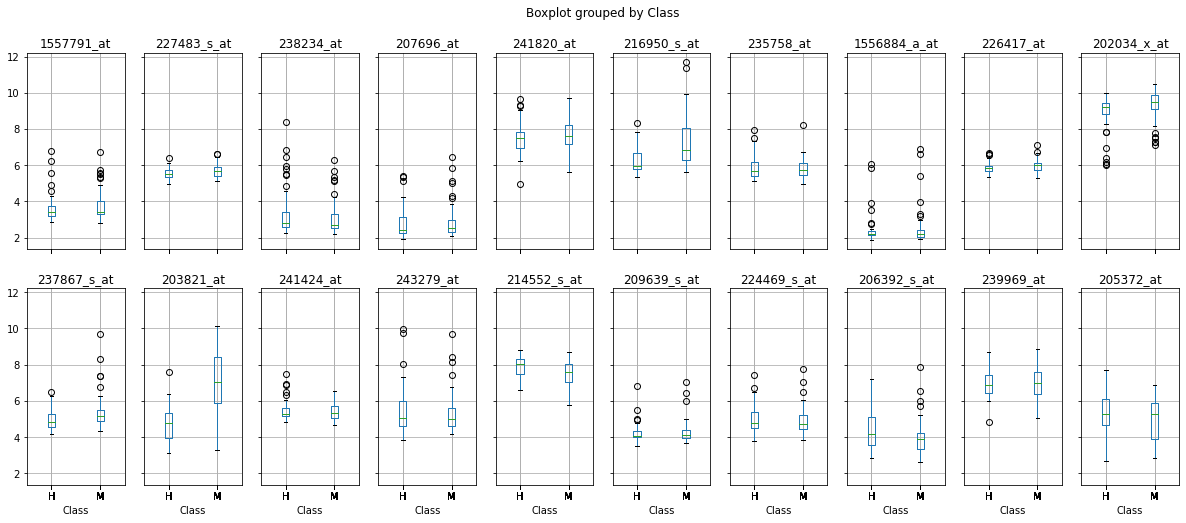

In [ ]:
boxplot = df.T.boxplot(column=random_genes, by='Class', layout=(2,10), figsize=(20,8))

#### b. WRS for differential expression (DE)

##### 1) Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

We have 99 samples: $N=99$

We have 49 $M$ samples: $B=49$

$$
μ_T=\frac{B(N+1)}{2}=\frac{49(99+1)}{2}=2450
$$

##### 2) Denote this sum of ranks by RS(g). What is the maximal value, c, that RS(g) can take?

If for $g$ all the $M$ samples are in the last rank, we get maximal $RS(g)=c$

$$
c = \sum_{i=51}^{99}i=3675
$$

##### 3) Under the null model, what is the probability of RS(g) = c? <br/> (Provide a formula for this and explain it)


In order to get all $M$ samples of $g$  in the last rank, there's only one way to order them in that way considering all of the possibilities of ordering the 49 $M$ samples within the 99 total samples.

$$
P(RS(g)=c)=\frac{1}{{99 \choose 49}}=1.98\times10^{-29}
$$

##### 4) Under the null model, what is the probability of RS(g) = c-1? what is the probability of RS(g) = c-2? <br/> (Provide formulas and explain them)

We can only get $RS(g)=c-1$ if the $M$ sample in rank 51 moves to rank 50,
hence, there's still only one way to order the $M$ samples.

$$
P(RS(g)=c)=P(RS(g)=c-1)=\frac{1}{{99 \choose 49}}=1.98\times10^{-29}
$$

There are 2 ways to get $RS(g)=c-2$


1.   If the $M$ sample in rank 51 moves to rank 49
2.   If the $M$ sample in rank 51 moves to rank 50, and the $M$ sample in rank 52 moves to rank 51

$$
P(RS(g)=c-2)=\frac{2}{{99 \choose 49}}=3.96\times10^{-29}
$$

##### 5) Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up). Compute the IQR for this distribution and present it on the plot with the histogram.

In [ ]:
df_ranks = df.copy()

In [ ]:
df_ranks.iloc[1:] = df_ranks.iloc[1:].apply(lambda x: x.rank(ascending=False), axis=1)

In [ ]:
sum_of_ranks = df_ranks.iloc[:,list(df_ranks.loc['Class'] == 'M')][1:].sum(axis=1)

In [ ]:
unique_sum_of_ranks = sum_of_ranks.nunique()
print(unique_sum_of_ranks)

2761


In [ ]:
bins = int(np.ceil(2 * unique_sum_of_ranks**(1/3)))
print(bins)

29


In [ ]:
q1 = sum_of_ranks.quantile(0.25)
q3 = sum_of_ranks.quantile(0.75)
print(f"Q1: {q1}")
print(f"Q3: {q3}")
print(f"IQR: {q3-q1}")

Q1: 2275.0
Q3: 2604.0
IQR: 329.0


We picked the number of bins using rice's rule: $k=⌈2\cdot\sqrt[3]{n}⌉=⌈2\cdot\sqrt[3]{2761}⌉=29$

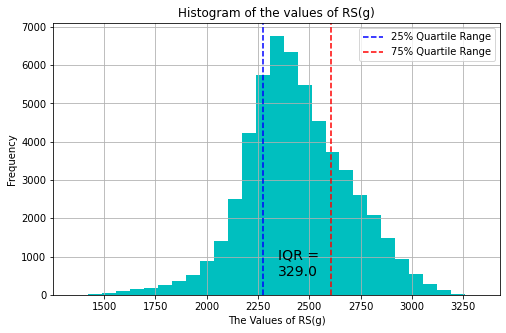

In [83]:
plt.figure(figsize=(8,5))
sum_of_ranks.hist(bins=bins, color='c')
plt.axvline(q1, color='b', linestyle='dashed', label='25% Quartile Range')
plt.axvline(q3, color='r', linestyle='dashed',label='75% Quartile Range')
plt.title(f'RS(g) Results Distribution - IQR: {q3-q1}')
plt.legend()
plt.ylabel('Frequency')
plt.xlabel('The Values of RS(g)')
plt.text(q1 + 70, 500, f"IQR =\n{q3-q1}", color="k", fontsize=14)
plt.title('Histogram of the values of RS(g)')
plt.show()

#### c. Differential Expression

The purpose is to determine the statistical significance of differential expression (DE) observed for each gene in H vs M. Evaluate the DE in both one-sided directions for every gene, using both Student t-test and WRS test.

Report the number of genes overexpressed in M vs H (M > H) at a p-value better (≤) than 0.07 and separately genes underexpressed in M vs H (M < H) at a p-value better than 0.07. For both directions use both a Student t-test and a WRS test.

In [ ]:
grouped_by_class = df.T.groupby('Class')
M_df = grouped_by_class.get_group('M').T.iloc[1:].astype(float)
H_df = grouped_by_class.get_group('H').T.iloc[1:].astype(float)

In [ ]:
stat_signif = pd.DataFrame(columns=['wrs_gt', 'wrs_lt', 't_test_gt', 't_test_lt'])

for g in tqdm(M_df.index):
    M_vals = M_df.loc[g]
    H_vals = H_df.loc[g]
    
    stat_signif.loc[g, 'wrs_gt'] = mannwhitneyu(M_vals, H_vals, alternative='greater')
    stat_signif.loc[g, 'wrs_lt'] = mannwhitneyu(M_vals, H_vals, alternative='less')
    stat_signif.loc[g, 't_test_gt'] = ttest_ind(M_vals, H_vals, alternative='greater')
    stat_signif.loc[g, 't_test_lt'] = ttest_ind(M_vals, H_vals, alternative='less')

  0%|          | 0/54628 [00:00<?, ?it/s]

In [ ]:
# Save only the p-values
stat_signif_p_values = stat_signif.applymap(lambda x: x[1])

In [ ]:
print('WRS Test')
print(f'Number of genes overexpressed M > H at p-value <= 0.07: {stat_signif_p_values[stat_signif_p_values["wrs_gt"] <= 0.07].shape[0]}')
print(f'Number of genes underexpressed M < H at p-value <= 0.07: {stat_signif_p_values[stat_signif_p_values["wrs_lt"] <= 0.07].shape[0]}\n')

print('Student t-test')
print(f'Number of genes overexpressed M > H at p-value <= 0.07: {stat_signif_p_values[stat_signif_p_values["t_test_gt"] <= 0.07].shape[0]}')
print(f'Number of genes underexpressed M < H at p-value <= 0.07: {stat_signif_p_values[stat_signif_p_values["t_test_lt"] <= 0.07].shape[0]}')

WRS Test
Number of genes overexpressed M > H at p-value <= 0.07: 10721
Number of genes underexpressed M < H at p-value <= 0.07: 10618

Student t-test
Number of genes overexpressed M > H at p-value <= 0.07: 8517
Number of genes underexpressed M < H at p-value <= 0.07: 8639


#### d. Correlations
Select the 80 most significant genes from each one of the one-sided WRS DE lists you computed in 3c. Generate a set of 160 genes, D, which is the union of the above two sets.

##### 1) Compute Kendall 𝜏 correlations in all pairs within D (160 choose 2 numbers). Represent the correlation matrix as a 160x160 heatmap.

In [ ]:
gt_genes = list(stat_signif_p_values.nsmallest(80, columns=['wrs_gt']).index)
lt_genes = list(stat_signif_p_values.nsmallest(80, columns=['wrs_lt']).index)

In [ ]:
signif_genes = gt_genes + lt_genes

In [ ]:
D = df.loc[signif_genes].T.astype(float)

In [ ]:
D_kendall = pd.DataFrame(D.corr(method='kendall').values,
                         index=D.columns,
                         columns=D.columns)

In [ ]:
D_kendall.head()

,208869_s_at,216248_s_at,204622_x_at,244054_at,203887_s_at,203888_at,217202_s_at,203574_at,241279_at,240103_at,211372_s_at,208868_s_at,211302_s_at,210423_s_at,218559_s_at,216015_s_at,222934_s_at,204621_s_at,205627_at,38037_at,205403_at,216236_s_at,1555167_s_at,203821_at,216016_at,205863_at,205239_at,1552772_at,244840_x_at,204620_s_at,201531_at,215990_s_at,217591_at,203708_at,235536_at,202672_s_at,220034_at,203853_s_at,205237_at,1558299_at,...,213888_s_at,231932_at,213405_at,223377_x_at,226693_at,1552320_a_at,64418_at,235304_at,1562697_at,225387_at,236751_at,236265_at,227877_at,219494_at,1560147_at,213317_at,219532_at,223671_x_at,239862_at,241582_at,203476_at,204236_at,218607_s_at,243764_at,229364_at,1562698_x_at,204352_at,219590_x_at,221081_s_at,221223_x_at,223588_at,224196_x_at,222108_at,230428_at,235310_at,235779_at,242874_at,1565882_at,224879_at,227626_at
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
208869_s_at,1.000000,0.664399,0.617811,0.433519,0.419913,0.408369,0.475984,0.584003,0.489177,0.457019,0.383220,0.662750,0.494949,0.468818,0.493713,0.485879,0.462791,0.545511,0.408782,0.508967,0.437229,0.570398,0.435993,0.522573,0.435580,0.545248,0.414141,0.366972,0.336219,0.445887,0.511029,0.434756,0.473098,0.525046,0.537827,0.491651,0.460159,0.475984,0.460159,0.349000,...,-0.250876,-0.269017,-0.327149,-0.370027,-0.307772,-0.204288,-0.294166,-0.381159,-0.264069,-0.287570,-0.317666,-0.264894,-0.173779,-0.323266,-0.295815,-0.318491,-0.234385,-0.196042,-0.302824,-0.334570,-0.241394,-0.274199,-0.219542,-0.269663,-0.227376,-0.264482,-0.254587,-0.200989,-0.217069,-0.379509,-0.345702,-0.198103,-0.234385,-0.255824,-0.285920,-0.281856,-0.346526,-0.377036,-0.216656,-0.323026
216248_s_at,0.664399,1.000000,0.851165,0.448361,0.386106,0.386931,0.466089,0.555968,0.484230,0.450423,0.379097,0.614100,0.502371,0.416864,0.459905,0.440528,0.469388,0.665086,0.388992,0.420738,0.412492,0.515152,0.392290,0.412080,0.389404,0.457844,0.469388,0.362025,0.396413,0.333746,0.523397,0.400948,0.492063,0.506081,0.490002,0.464440,0.423874,0.464440,0.378518,0.363843,...,-0.328386,-0.371264,-0.439291,-0.486291,-0.351474,-0.286745,-0.371676,-0.426510,-0.287157,-0.374150,-0.371264,-0.334982,-0.280148,-0.446552,-0.274376,-0.355597,-0.301175,-0.267780,-0.340754,-0.400536,-0.233972,-0.341408,-0.337456,-0.343057,-0.290868,-0.291692,-0.342816,-0.252113,-0.326737,-0.494125,-0.415791,-0.264069,-0.268192,-0.289631,-0.335395,-0.349485,-0.416615,-0.401773,-0.238095,-0.417852
204622_x_at,0.617811,0.851165,1.000000,0.457019,0.373325,0.392290,0.442589,0.554731,0.450010,0.400536,0.349825,0.590600,0.506081,0.398309,0.451247,0.426922,0.448361,0.639109,0.390229,0.398062,0.401361,0.457019,0.375387,0.367141,0.367553,0.456607,0.452484,0.378930,0.369615,0.325912,0.495774,0.389817,0.454545,0.496599,0.449186,0.445887,0.417277,0.449186,0.384703,0.343640,...,-0.299114,-0.365904,-0.425685,-0.479283,-0.356834,-0.282210,-0.367141,-0.424449,-0.289219,-0.370439,-0.375799,-0.340342,-0.301175,-0.413978,-0.239332,-0.342816,-0.326324,-0.268192,-0.337044,-0.411668,-0.210472,-0.330275,-0.327149,-0.341820,-0.285508,-0.287157,-0.325912,-0.256648,-0.319728,-0.492063,-0.400536,-0.260359,-0.267780,-0.280148,-0.324263,-0.354845,-0.411255,-0.404659,-0.261596,-0.400124
244054_at,0.433519,0.448361,0.457019,1.000000,0.522160,0.531231,0.534529,0.562564,0.460317,0.576582,0.529994,0.445887,0.490002,0.519534,0.515976,0.467739,0.566687,0.441192,0.534941,0.459493,0.458668,0.447537,0.567100,0.431045,0.560091,0.547722,0.322614,0.555407,0.554731,0.497011,0.525046,0.484230,0.514327,0.452484,0.397650,0.409194,0.531079,0.466914,0.505103,0.511441,...,-0.332509,-0.358895,-0.317254,-0.300763,-0.342404,-0.394764,-0.347763,-0.291280,-0.394352,-0.363430,-0.340754,-0.292105,-0.388167,-0.375219,-0.269429,-0.352298,-0.382808,-0.411255,-0.245104,-0.323026,-0.273552,-0.281620,-0.369615,-0.287805,-0.397238,-0.381571,-0.312307,-0.413729,-0.281385,-0.301175,-0.226139,-0.401773,-0.313544,-0.297877,-0.2

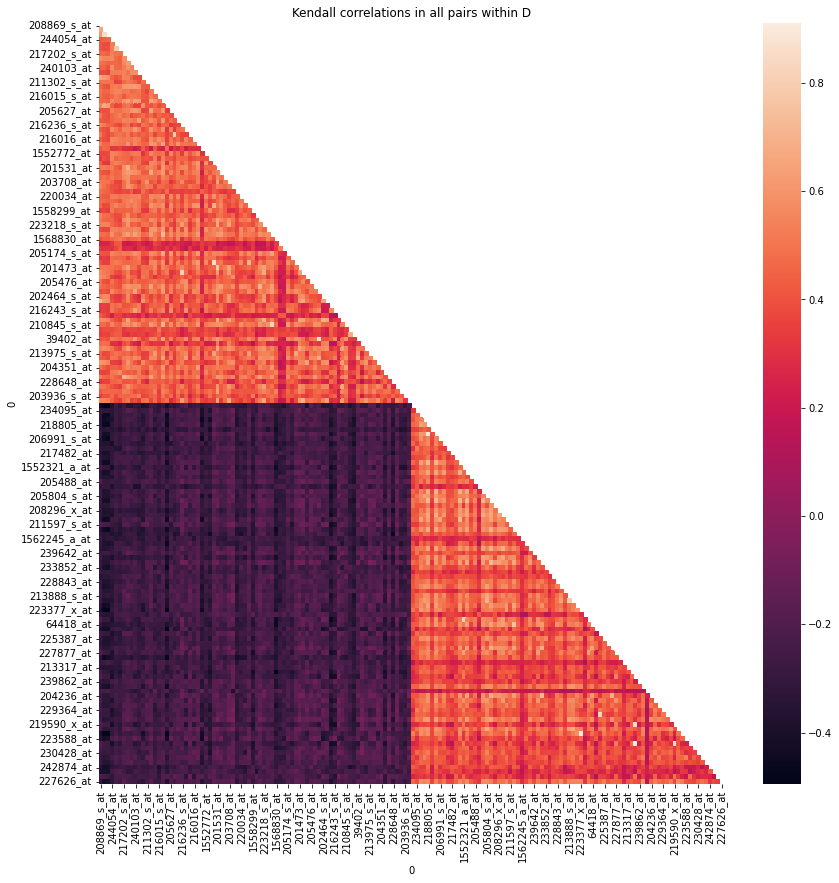

In [ ]:
mask = np.zeros_like(D_kendall)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(14,14))
sns.heatmap(D_kendall, mask=mask)
plt.title("Kendall correlations in all pairs within D")
plt.show()

##### 2) Under a NULL model that assumes that genes are pairwise independent, what is the expected value for 𝜏?

If $X$ and $Y$ are independent, then we would expect 𝜏 to be approximately zero. <br/>
Under a null model that assumes that the genes are pairwise independent, we expect that the values for the Kendall results ( 𝜏 ) will be about half with positive correlations results and a about half with negative correlations results since we generated the matrix D (160 x 160) using a union of 2 non-independet groups (overexpressed and underexpressed). <br/>
The overexpressed genes will act/behave the same according to their expression levels, for instance, if one gene from this group will be high, we expect that an additional gene from this group will be higher as well (and the same for the underexpressed). However, if one gene from the overexpressed group will be high, we expect that a different gene from the underexpressed group will be lower (referring to a negative correlation). <br/>
Therefore, the observed mean of the numbers within the D matrix will be around zero, since a half will be positive correlations and a half will be negative correlations.

In [ ]:
print(f'Mean of kendall correlations of all pairs within D: {np.round(D_kendall.stack().mean(),3)}')

Mean of kendall correlations of all pairs within D: 0.09


##### 3) Now compute the Kendall 𝜏 correlations in all 80 choose 2 pairs from the overexpressed genes in D. Present your results on a histogram. What is the average value you observed? Compare it to the value in the above section. Explain.

In [ ]:
over_D = df.loc[gt_genes].T.astype(float)

In [ ]:
over_D_kendall = pd.DataFrame(over_D.corr(method='kendall').values,
                              index=over_D.columns,
                              columns=over_D.columns)

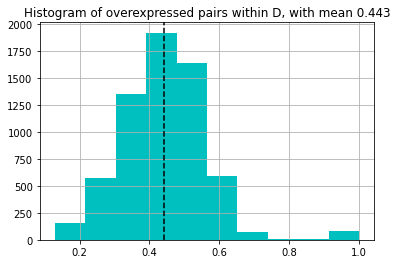

In [ ]:
over_D_kendall.stack().hist(color='c')
over_D_kendal_mean = np.round(over_D_kendall.stack().mean(),3)
plt.title(f'Histogram of overexpressed pairs within D, with mean {over_D_kendal_mean}')
plt.axvline(over_D_kendal_mean, color='k', linestyle='dashed')
plt.show()

Looking at the top 80 overexpressed genes in $D$:

> We get positive kendall correlation as they all have significance of having Myocardial infraction.

Looking at the top 80 overexpressed genes and top 80 underexpressed genes in $D$:

> We can see from the heatmap that we have positive kendall correlations between the top 80 underexpressed genes, and negative kendall correlations between the top 80 overexpressed genes and the top 80 underexpressed genes.<br/>
Hence, looking at the heatmap we intuitively will get a mean close to 0 as we have an almost equal amount of positively correlated pairs and negatively correlated pairs.


##### 4) What can you report about co-expression of genes in D (co-expression is inferred from the correlation of the expression levels of genes, across a set of samples)?

As said above, we can report that the genes that are overexpressed will all have positive kendall correlations between each other, meaning that the higher gene expression for these genes the more likely to have a myocardial sample.

Same with the genes that underexpressed, the higher gene expression for these genes the more likely to have a healthy sample.

Having negative kendall correlations between the overexpressed and underexpressed genes, means that the higher the gene expression of the overexpressed genes is and the lower the gene expression of the underexpressed genes is the more likely to have a myocardial sample, and vice versa the more likely to have a healthy sample.

##### 5) What can you say about how many co-expressed pairs we would observe (in the entire dataset) at FDR=0.05? Explain your answer.

To calculate the number of co-expressed pairs in the entire dataset at $FDR=0.05$, we should count the pairs of genes (out of all possible pairs) whose pvalue in the empirical FDR equation meets the defined FDR threshold. Given that our dataset contains 54,677 distinct genes, the null model predicts that we will have ${54677 \choose 2} \cdot 0.05 ≈ 7.5 \cdot 10^7$ pairs of genes at FDR = 0.05

$FDR(p) = \frac{p⋅N}{O(p)} = 0.05 $

Let's also calculate the number of pairs of genes in the set of 80 most significant genes, with $FDR=0.05$:

In [ ]:
D_p_values = np.zeros((D.shape[1], D.shape[1]))

for i, gene_x in enumerate(signif_genes):
    for j, gene_y in enumerate(signif_genes):
        X = D[gene_x]
        Y = D[gene_y]
        r, p = kendalltau(X, Y)
        D_p_values[i, j] = p

In [ ]:
number_of_pairs = np.sort(D_p_values.flatten()).size

In [ ]:
def get_k(pvals, fdrs, number_of_pairs):
    fdrs_dict = {}
    for fdr in fdrs:
        for i in range(1, number_of_pairs):
            calc_fdr = (pvals[i-1] * number_of_pairs) / i
            if fdr < calc_fdr:
                fdrs_dict[fdr] = i-1
                break
    return fdrs_dict

In [ ]:
result = get_k(np.sort(D_p_values.flatten()),[0.05],number_of_pairs)
print(f'The total number of pairs we observe in FDR=0.05 is: {result[0.05]}/2 = {result[0.05]/2}')

The total number of pairs we observe in FDR=0.05 is: 24866/2 = 12433.0


We can conclude that according to the FDR correction, for the total number of pairs we observed is 12,433 (= 24,866 / 2, since the matrix is symmetric) pairs out of 12720 or ${160 \choose 2}$.

##### 6) What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D?

**Advantages**:

1. By looking at all the genes in the study and computing their co-expression we could possibly discover genes that on their own don't have much significance in their expression when calculating WRS, but by looking at their correlations we could discover other interesting information.
2. Computing the co-expression for all the genes in the study will contribute access to a large part of the full population, thus it helps us in obtaining quality and precise statistical results.
3. When using all the genes in the study, we should get lower p-values for rejecting our null hypothesis, i.e. our results will be more statistically significant against the genes in D.

For example, find which genes are active simultaneously, which often indicates they are active in the same biological process, but do not normally confer information about causality or distinguish between regulatory and regulated genes.

**Disadvantages**:

1. To compute co-expression for all genes we require a lot of computing power. By using an enhanced Merge sort algorithm the complexity of kendall tau can be $O(n\log n)$, hence, going from 160 genes to all 54628 will take a lot more time.
2. Conducting multiple testing will present us with more spurious results and will lead us to misinterpretation based on the given data (although there are tools that we can use to detect these misinterpretations).
3. Visualization and inspection, it is challenging to achieve any conclusions from the visualization that contains enormous data points.

#### e. Plots and Conclusions of the DE and correlation analysis

##### 1) Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c.
State, for each comparison, the number of genes, k, at which we observe:

> a) FDR = 0.05

> b) FDR = 0.01

> c) FDR = 0.005

If these events are not observed at any k>0, then make that statement.

In [ ]:
total_wrs_over_expressed= stat_signif_p_values.T.loc['wrs_gt'].sort_values()
total_t_test_over_expressed = stat_signif_p_values.T.loc['t_test_gt'].sort_values()


In [ ]:
def calc_fdr(p_values, alpha, delimit=True):
    max_i = np.NINF
    sort_ind = np.argsort(p_values)
    p_values = np.take(p_values, sort_ind)

    N = len(p_values)
    idx = np.arange(1, N + 1)
    fdr = np.zeros(N + 1)

    for i, p in zip(idx, p_values):
        fdr[i] = p * N / i
        if fdr[i] <= alpha:
            if i > max_i:
                max_i = i
    
    if delimit:
        fdr[fdr > 1] = 1
    
    fdr_ = np.empty_like(fdr[1:])
    fdr_[sort_ind] = fdr[1:]

    return fdr_, max_i

In [ ]:

def overabundance_values(fdr, p_vals):
    # sort the FDR results and the p-values
    fdr.sort()
    sort_ind = np.argsort(p_vals)
    p_i = np.take(p_vals, sort_ind)

    # set values under the null model
    N = len(p_vals)
    x = np.arange(0, 1.1, 0.1)
    y = x * N

    # compute the actual p-values occurrences
    idx = []
    for p, f in zip(p_i, fdr):
        i = p * N / f
        idx.append(i)

    return x, y, p_i, idx

def plot_DE_overabundance(wrs_over_expressed, t_test_over_expressed, alpha):
    wrs_p_vals = wrs_over_expressed.values.flatten()
    wrs_fdr, wrs_max_i = calc_fdr(wrs_p_vals, alpha, delimit=True)
    wrs_x, wrs_y, wrs_p_i, wrs_idx = overabundance_values(wrs_fdr, wrs_p_vals)
    t_test_p_vals = t_test_over_expressed.values.flatten()
    t_test_fdr, t_test_max_i = calc_fdr(t_test_p_vals, alpha, delimit=True)
    t_test_x, t_test_y, t_test_p_i, t_test_idx = overabundance_values(t_test_fdr, t_test_p_vals)

    # results
    print(f'---- alpha: {alpha} ----')
    print(f'We observed overexpressed {wrs_max_i} genes at FDR = {alpha}, using a WRS test')
    print(f'We observed overexpressed {t_test_max_i} genes at FDR = {alpha}, using a Student t-test')

    # visualization
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.0, 6.0))

    ax1.plot(wrs_x, wrs_y, label='expected')  # the expected occurrences under the null model
    ax1.plot(wrs_p_i, wrs_idx, label='actual')  # the actual occurrences
    ax1.axvline(wrs_p_i[wrs_max_i], 0, 1, ls='--', c='r', label=f'FDR={alpha}')
    ax1.axhline(wrs_max_i, 0, 1, ls='--', c='r')
    ax1.set_title('Overexpressed genes - WRS Results')
    ax1.set_xlabel('P-Values')
    ax1.set_ylabel('Number of genes')
    ax1.legend()

    ax2.plot(t_test_x, t_test_y, label='expected')  # the expected occurrences under the null model
    ax2.plot(t_test_p_i, t_test_idx, label='actual')  # the actual occurrences
    ax2.axvline(t_test_p_i[t_test_max_i], 0, 1, ls='--', c='r', label=f'FDR={alpha}')
    ax2.axhline(t_test_max_i, 0, 1, ls='--', c='r')
    ax2.set_title('Overexpressed genes - Student t-test Results')
    ax2.set_xlabel('P-Values')
    ax2.set_ylabel('Number of genes')
    ax2.legend()

    f.suptitle(f'DE overabundance plots - alpha:{alpha}')
    plt.show()

---- alpha: 0.05 ----
We observed overexpressed 2784 genes at FDR = 0.05, using a WRS test
We observed overexpressed 2104 genes at FDR = 0.05, using a Student t-test


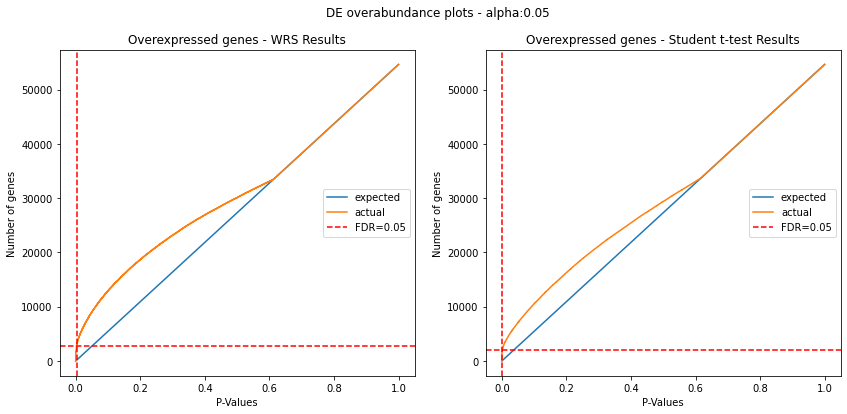

---- alpha: 0.01 ----
We observed overexpressed 1601 genes at FDR = 0.01, using a WRS test
We observed overexpressed 1305 genes at FDR = 0.01, using a Student t-test


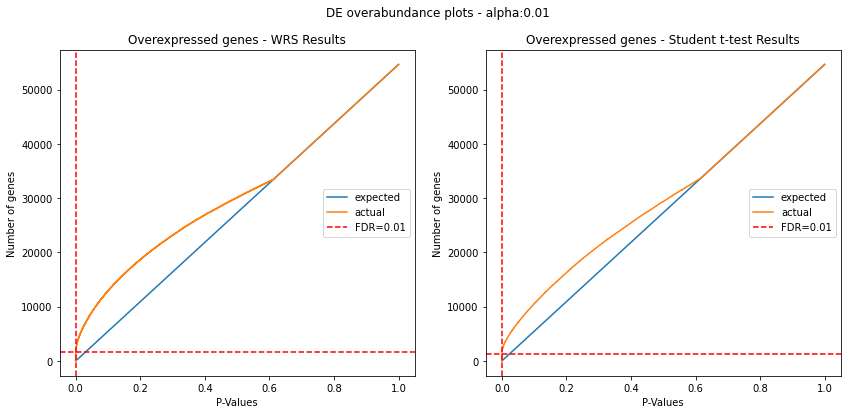

---- alpha: 0.005 ----
We observed overexpressed 1322 genes at FDR = 0.005, using a WRS test
We observed overexpressed 1104 genes at FDR = 0.005, using a Student t-test


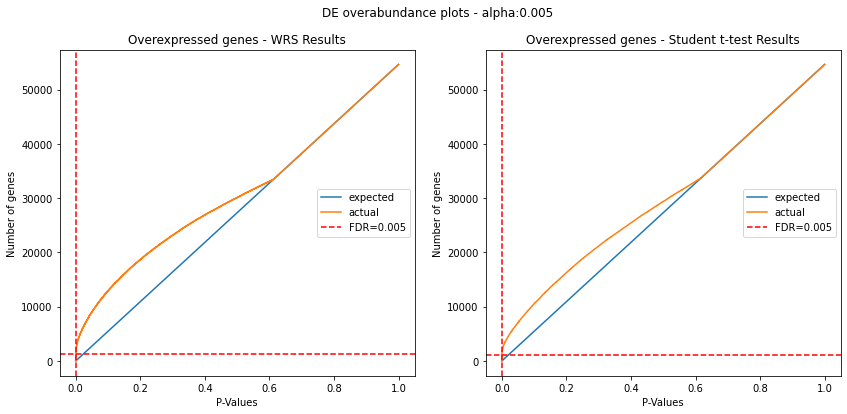

In [ ]:
alphas = [0.05, 0.01, 0.005]
for alpha in alphas:
    plot_DE_overabundance(total_wrs_over_expressed, total_t_test_over_expressed, alpha)

##### 2) Select any 3 differentially expressed genes, from D (which was defined in 3d), and produce a graphical representation of their expression patterns that demonstrates the observed DE.

#### Graphical Representation Of The Differentially Expressed Genes
We selected 3 differentially expressed genes, from D (which was defined in 3.d), and produced a graphical representation of their expression patterns that demonstrates the observed DE.

The DE genes (using the WRS test results):
* From the <b>overexpressed</b> list:
    * 216248_s_at
    * 203888_at
* From the <b>underexpressed</b> list:
    * 206978_at

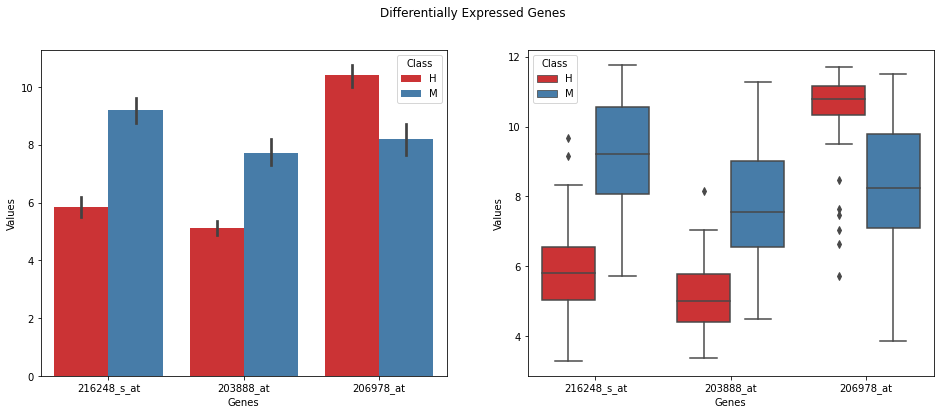

In [ ]:
# set the Dataframe for these genes
df_de_genes = df.T[['216248_s_at', '203888_at', '206978_at', 'Class']]

# fix the table structure for the visualization
df_de_genes = df_de_genes.melt(id_vars=['Class'], var_name='Genes', value_name='Values')

# visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.0, 6.0))
df_de_genes['Class'] = df_de_genes['Class'].replace({0: 'H', 1: 'M'})
sns.barplot(x='Genes', y='Values', hue='Class', data=df_de_genes, palette="Set1", ax=ax1)
sns.boxplot(x='Genes', y='Values', hue='Class', data=df_de_genes, palette="Set1", ax=ax2)
f.suptitle('Differentially Expressed Genes')
plt.show()

##### 3) Heatmap <br/> Draw a heatmap representation of the expression values of the genes in D (from 3d), across the entire cohort (all samples). Order the genes and the samples to produce the maximal visual effect.

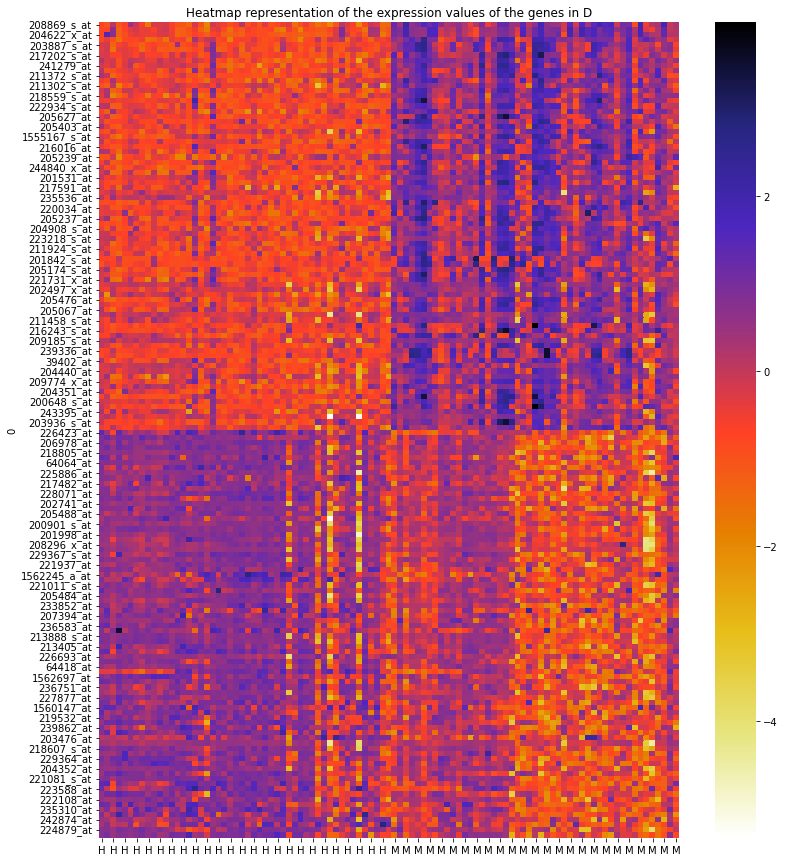

In [79]:
# We have the samples ordered by H then M
# We have the genes ordered by the overexpressed sorted then underexpressed sorted, both by p-values
# We also normalize the expression values for each gene

H_df.columns = ['H'] * H_df.shape[1]
M_df.columns = ['M'] * M_df.shape[1]

temp = pd.concat((H_df.loc[signif_genes].T, M_df.loc[signif_genes].T)).T
df_norm_row = temp.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
plt.figure(figsize=(13,15))
sns.heatmap(df_norm_row, cmap='CMRmap_r')
plt.title("Heatmap representation of the expression values of the genes in D")
plt.show()